In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.features.cleaning import clean_data, split_X_and_y_data
from src.utils import get_project_root

## Pre-processing (TODO: recode tumor size and check for other known descriptors like the MGMT gene and prescence of genetic mutation)

In [4]:
# dir_root = get_project_root()
dir_data = './data'
filename_data_brain = os.path.join(
    # dir_root,
    dir_data,
    'survival_brain_2000_to_2020_seer_2022_db.csv'
)
data_raw = pd.read_csv(filename_data_brain)

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_13697/520045369.py:8: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(filename_data_brain)


In [5]:
data = clean_data(data_raw)

In [6]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from scipy import stats

In [7]:
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=2984,
    shuffle=True,
    stratify=data['Vital status recode (study cutoff used)']
)

X_train, y_train = split_X_and_y_data(data_train)
X_test, y_test = split_X_and_y_data(data_test)

In [8]:
X_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 61061 entries, 36640 to 46191
Data columns (total 128 columns):
 #    Column                                                                 Non-Null Count  Dtype   
---   ------                                                                 --------------  -----   
 0    Age recode with <1 year olds                                           61061 non-null  int64   
 1    Sex                                                                    61061 non-null  category
 2    Year of diagnosis                                                      61061 non-null  int64   
 3    PRCDA 2020                                                             61061 non-null  object  
 4    Race recode (W, B, AI, API)                                            61061 non-null  category
 5    Origin recode NHIA (Hispanic, Non-Hisp)                                61061 non-null  category
 6    Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)           

In [115]:
def get_training_subset(X_train):
    categorical_columns = [
        'Sex',
        'Race recode (W, B, AI, API)',
        'Origin recode NHIA (Hispanic, Non-Hisp)',
        'Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)',
        # 'SEER cause-specific death classification',
        # 'SEER other cause of death classification',
        'Type of Reporting Source',
        'Marital status at diagnosis',
        'Rural-Urban Continuum Code',
        # 'End Calc Vital Status (Adjusted)',
    ]
    numerical_columns = [
        'Year of diagnosis',
        # 'Year of follow-up recode',
        'Total number of in situ/malignant tumors for patient',
        # 'Year of diagnosis (2000-2019 by 5)',
    ]
    other_useful_columns = [
        # 'Alive at last contact',
        'Age recode with <1 year olds',
        'Median household income inflation adj to 2021 (thousands USD)'
    ]
    all_useful_columns = categorical_columns + \
        numerical_columns + other_useful_columns

    # Make a smaller dataframe for testing
    X_subset_train = X_train[all_useful_columns]
    assert all(X_subset_train.isna() == False)
    return X_subset_train

In [116]:
X_subset_train = get_training_subset(X_train)
X_subset_train.head()

,Sex,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",Type of Reporting Source,Marital status at diagnosis,Rural-Urban Continuum Code,Year of diagnosis,Total number of in situ/malignant tumors for patient,Age recode with <1 year olds,Median household income inflation adj to 2021 (thousands USD)
36640,Female,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,Hospital inpatient/outpatient or clinic,Married (including common law),Counties in metropolitan areas of lt 250 thous...,2013,1,55,50
58939,Male,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,Hospital inpatient/outpatient or clinic,Married (including common law),Counties in metropolitan areas of lt 250 thous...,2017,1,65,50
3662,Female,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,Hospital inpatient/outpatient or clinic,Single (never married),Counties in metropolitan areas ge 1 million pop,2009,1,20,50
23396,Female,White,Spanish-Hispanic-Latino,Hispanic (All Races),Hospital inpatient/outpatient or clinic,Married (including common law),Counties in metropolitan areas ge 1 million pop,2007,3,45,65
28036,Male,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,Hospital inpatient/outpatient or clinic,Married (including common law),Counties in metropolitan areas ge 1 million pop,2008,1,50,75


In [86]:
# One-hot encoding for categorical columns
X_train_numeric = OneHotEncoder().fit_transform(X_subset_train)
data_x_numeric = X_train_numeric
X_train_numeric.head()

AttributeError: 'csr_matrix' object has no attribute 'head'

In [11]:
y_train

,Event indicator,Survival months
36640,True,4
58939,True,1
3662,False,133
23396,False,155
28036,True,13
...,...,...
17826,False,83
42622,True,4
39570,True,8
48413,True,34


In [12]:
data_y = y_train.to_records(index=False)
data_y

rec.array([( True,   4), ( True,   1), (False, 133), ..., ( True,   8),
           ( True,  34), ( True,   7)],
          dtype=[('Event indicator', '?'), ('Survival months', '<i8')])

## Model training

In [9]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

In [14]:
Xt = data_x_numeric
y = data_y

alphas = 10.0 ** np.linspace(-2, 6, 20)
coefficients = {}
scores = []

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    score = cph.score(Xt, y)
    scores.append(score)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(
    index="feature", columns="alpha").set_index(Xt.columns)

In [15]:
# Lower alpha values result in larger coefficients and a higher c-index
for (i, alpha) in enumerate(alphas):
    print(f'alpha={alpha:.2g},\t\tc-index={scores[i]:.9f}')

alpha=0.01,		c-index=0.743990434
alpha=0.026,		c-index=0.743990442
alpha=0.07,		c-index=0.743990379
alpha=0.18,		c-index=0.743990409
alpha=0.48,		c-index=0.743990212
alpha=1.3,		c-index=0.743989674
alpha=3.4,		c-index=0.743988187
alpha=8.9,		c-index=0.743985477
alpha=23,		c-index=0.743970587
alpha=62,		c-index=0.743914778
alpha=1.6e+02,		c-index=0.743774258
alpha=4.3e+02,		c-index=0.743452969
alpha=1.1e+03,		c-index=0.742825855
alpha=3e+03,		c-index=0.741851193
alpha=7.8e+03,		c-index=0.740699971
alpha=2.1e+04,		c-index=0.739613675
alpha=5.5e+04,		c-index=0.738788811
alpha=1.4e+05,		c-index=0.738290678
alpha=3.8e+05,		c-index=0.737996897
alpha=1e+06,		c-index=0.737642531


In [16]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

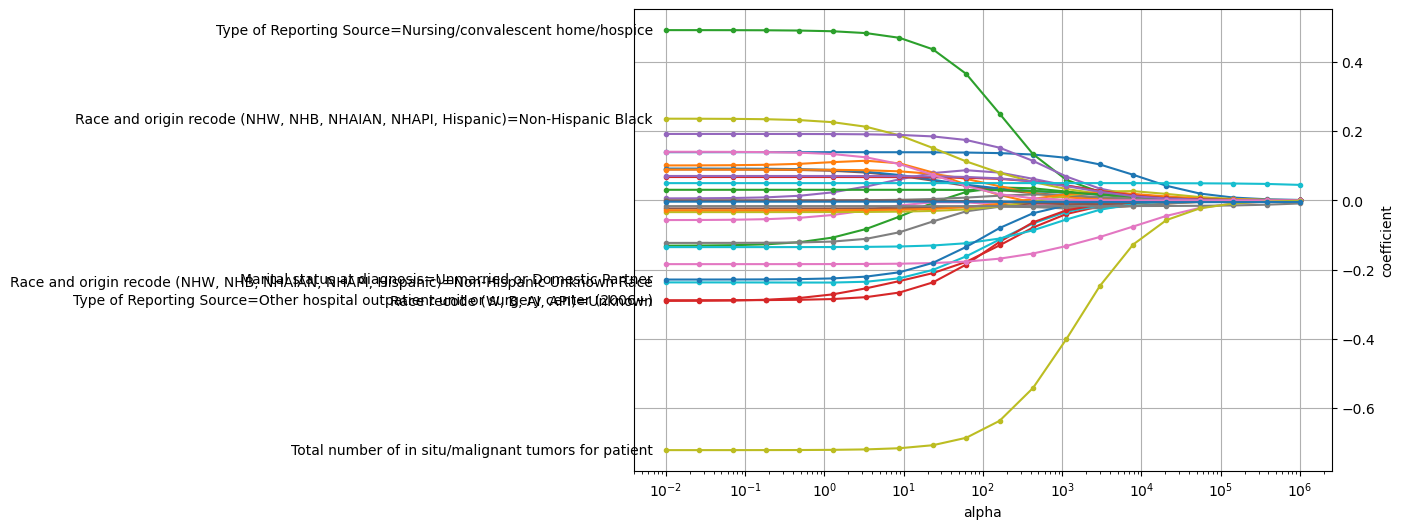

In [17]:
plot_coefficients(coefficients, n_highlight=7)

In [18]:
# cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=1e-30)
cox_lasso = CoxnetSurvivalAnalysis(
    l1_ratio=1.0, alpha_min_ratio=1e-30, fit_baseline_model=True)
cox_lasso.fit(Xt, y)
print(f'c-index={cox_lasso.score(Xt, y)}')

c-index=0.7439860746668687


In [19]:
# Actual set of estimated alphas used by the model
cox_lasso.alphas_

array([9.09403925e+00, 4.52612477e+00, 2.25266296e+00, 1.12115566e+00,
       5.58001816e-01, 2.77718819e-01, 1.38221310e-01, 6.87930719e-02,
       3.42384740e-02, 1.70405692e-02, 8.48113144e-03, 4.22107910e-03,
       2.10084102e-03, 1.04559352e-03, 5.20394361e-04, 2.59001500e-04,
       1.28905657e-04, 6.41566491e-05, 3.19309155e-05, 1.58920919e-05])

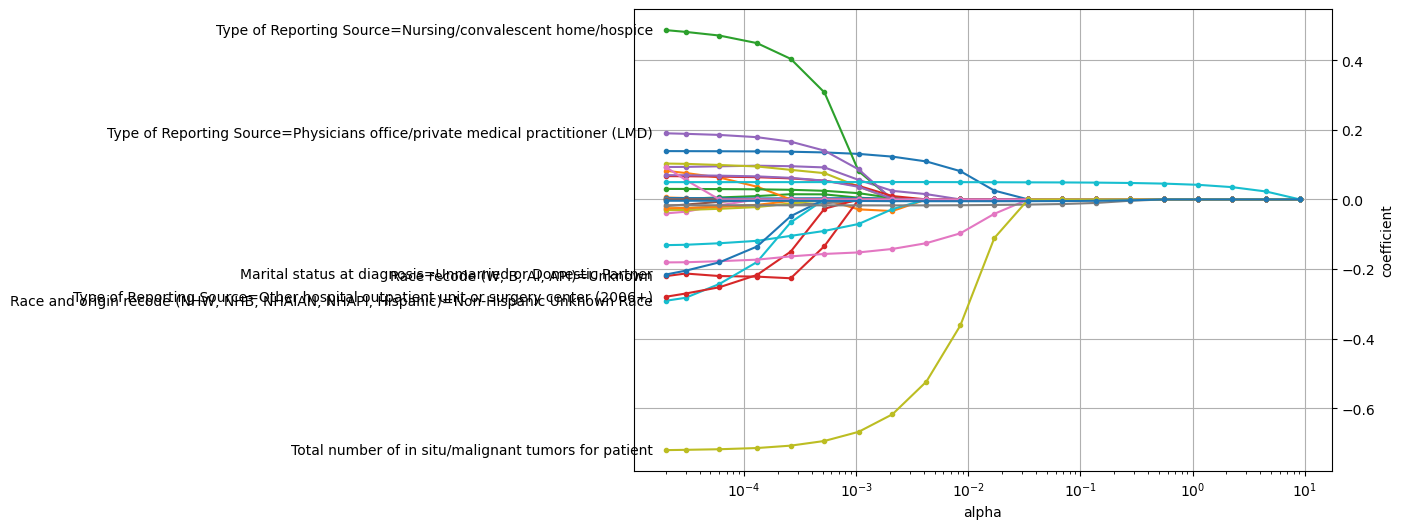

In [20]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=7)

In [21]:
# cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.1, alpha_min_ratio=1e-50)
cox_elastic_net = CoxnetSurvivalAnalysis(
    l1_ratio=0.1, alpha_min_ratio=1e-50, fit_baseline_model=True)
cox_elastic_net.fit(Xt, y)
print(f'c-index={cox_elastic_net.score(Xt, y)}')

c-index=0.7439881438510484


In [22]:
# Actual set of estimated alphas used by the model
cox_elastic_net.alphas_

array([9.09403925e+01, 2.84253826e+01, 8.88496690e+00, 2.77718819e+00,
       8.68070113e-01, 2.71334051e-01, 8.48113144e-02, 2.65096070e-02,
       8.28614987e-03, 2.59001500e-03, 8.09565093e-04, 2.53047044e-04,
       7.90953157e-05, 2.47229482e-05, 7.72769110e-06])

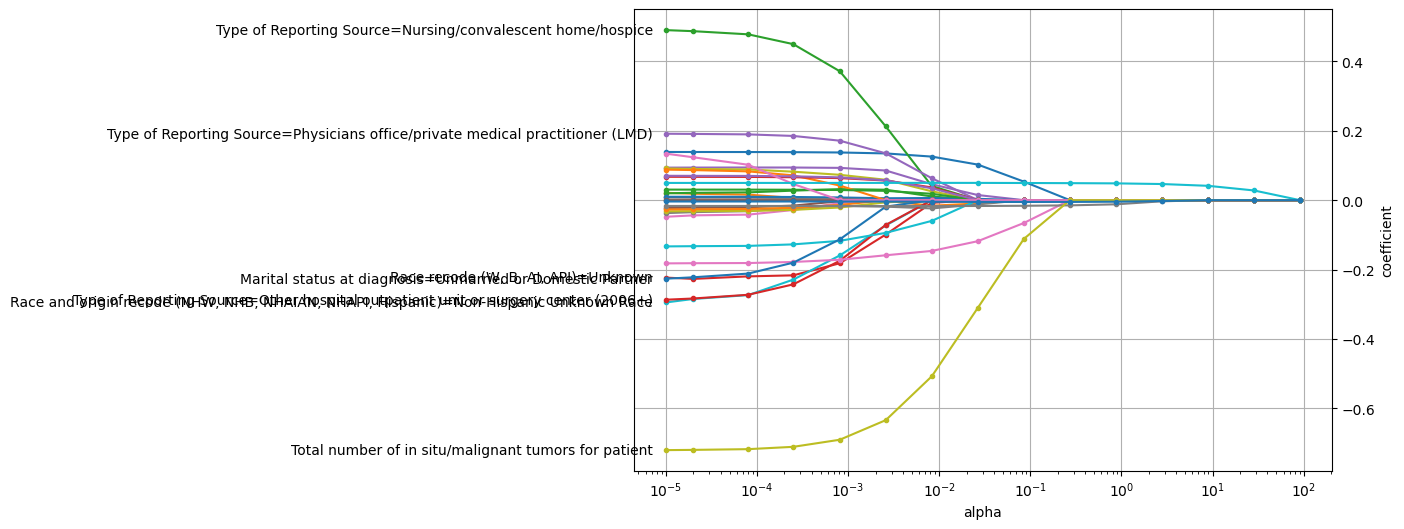

In [23]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(
        cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=7)

## Prediction

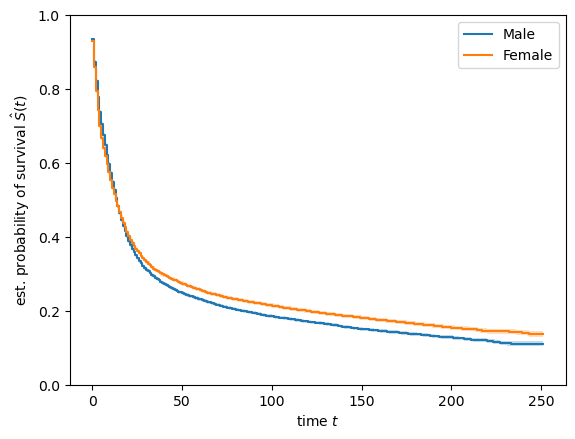

In [24]:
for sex in ("Male", "Female"):
    mask_sex = X_train["Sex"] == sex
    time_sex, survival_prob_sex, conf_int = kaplan_meier_estimator(
        y_train["Event indicator"][mask_sex],
        y_train["Survival months"][mask_sex],
        conf_type="log-log",
    )

    plt.step(time_sex, survival_prob_sex,
             where="post", label=sex)
    plt.fill_between(
        time_sex, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

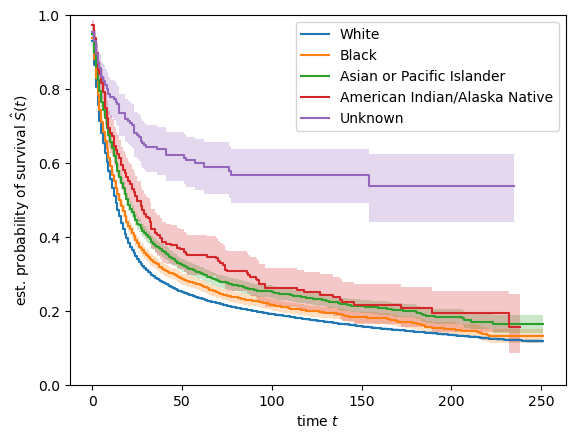

In [25]:
for race_recode in ("White", "Black", "Asian or Pacific Islander", "American Indian/Alaska Native", "Unknown"):
    mask_race = X_subset_train["Race recode (W, B, AI, API)"] == race_recode
    time_race, survival_prob_race, conf_int = kaplan_meier_estimator(
        y_train["Event indicator"][mask_race],
        y_train["Survival months"][mask_race],
        conf_type="log-log",
    )

    plt.step(time_race, survival_prob_race,
             where="post", label=race_recode)
    plt.fill_between(
        time_race, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [26]:
first_case = data_x_numeric.iloc[0]
synthetic_cases = [first_case.copy() for i in range(4)]
synthetic_ages = [51, 6, 80, 30]
for synthetic_case, synthetic_age in zip(synthetic_cases, synthetic_ages):
    synthetic_case['Age recode with <1 year olds'] = synthetic_age

print("Synthetic ages:", list(map(lambda x: x['Age recode with <1 year olds'], synthetic_cases)))

Synthetic ages: [51.0, 6.0, 80.0, 30.0]


In [27]:
X_to_pred = pd.DataFrame.from_dict(
    {i: synthetic_case for i, synthetic_case in enumerate(synthetic_cases)},
    columns=data_x_numeric.columns,
    orient="index",
)
X_to_pred

,Sex=Male,"Race recode (W, B, AI, API)=Asian or Pacific Islander","Race recode (W, B, AI, API)=Black","Race recode (W, B, AI, API)=Unknown","Race recode (W, B, AI, API)=White","Origin recode NHIA (Hispanic, Non-Hisp)=Spanish-Hispanic-Latino","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic American Indian/Alaska Native","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Asian or Pacific Islander","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Black","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic Unknown Race",...,Marital status at diagnosis=Widowed,"Rural-Urban Continuum Code=Counties in metropolitan areas of 250,000 to 1 million pop",Rural-Urban Continuum Code=Counties in metropolitan areas of lt 250 thousand pop,Rural-Urban Continuum Code=Nonmetropolitan counties adjacent to a metropolitan area,Rural-Urban Continuum Code=Nonmetropolitan counties not adjacent to a metropolitan area,Rural-Urban Continuum Code=Unknown/missing/no match (Alaska or Hawaii - Entire State),Year of diagnosis,Total number of in situ/malignant tumors for patient,Age recode with <1 year olds,Median household income inflation adj to 2021 (thousands USD)
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2013.0,1.0,51.0,50.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2013.0,1.0,6.0,50.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2013.0,1.0,80.0,50.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2013.0,1.0,30.0,50.0


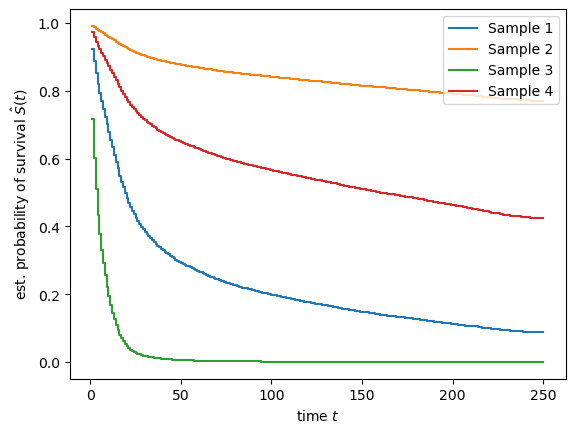

In [28]:
pred_surv = cox_lasso.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right")

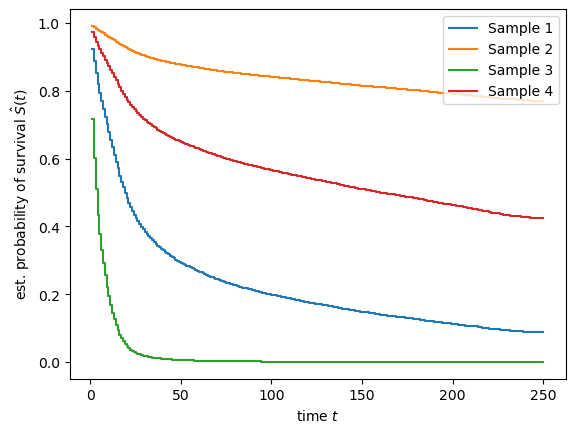

In [29]:
pred_surv = cox_elastic_net.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper right")

## TODO: Grid-search for best $\alpha$ and $l_1$ ratio

In [30]:
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['Sex']),
    (StandardScaler(), ['Age recode with <1 year olds']),
    remainder='drop',
    n_jobs=-1,
)

In [16]:
pipeline = make_pipeline(
    column_transformer,
    # SelectKBest(fit_and_score_features, k=1),
    CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=True)
)

cv_search_dist = {
    'coxnetsurvivalanalysis__l1_ratio': np.linspace(0.8, 1, 5)
}
# cv_search = RandomizedSearchCV(
cv_search = GridSearchCV(
    pipeline,
    cv_search_dist,
    cv=3,
    n_jobs=-1,
)
cv_search.fit(X_train, y_train.to_records(index=False))
# cv_search.score(X_train, y_train.to_records(index=False))

/Users/ajy/miniforge_86/envs/cancer_survival/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ajy/miniforge_86/envs/cancer_survival/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ajy/miniforge_86/envs/cancer_survival/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ajy/miniforge_86/envs/cancer_survival/lib/python3.12/site-packages/sklearn/pipeline.py", line 760, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ajy/miniforge_86

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='constant')),
                                                                                         ('dataframetransformer',
                                                                                          DataFrameTransformer()),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Sex']),
                                                                        ('standardscaler-1',
                                                                         St...
                                                                        ('standardscaler-4',
                                                                         StandardScaler(),
                                                                         ['Combined '
                                                                          'Tumor '
                                                                          'Size']),
                                                                        ('standardscaler-5',
                                                                         StandardScaler(),
                                                                         ['No '
                                                                          'tumor '
                                                                          'found']),
                                                                        ('standardscaler-6',
                                                                         StandardScaler(),
                                                                         ['Unknown '
                                                                          'tumor '
                                                                          'size'])])),
                                       ('coxnetsurvivalanalysis',
                                        CoxnetSurvivalAnalysis(fit_baseline_model=True,
                                                               verbose=True))]),
             n_jobs=-1,
             param_grid={'coxnetsurvivalanalysis__l1_ratio': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])})

In [32]:
cv_search.score(X_train, y_train.to_records(index=False))

0.7345382747933215

In [33]:
cv_search.best_params_

{'coxnetsurvivalanalysis__l1_ratio': 0.8}

In [34]:
X_to_pred = pd.DataFrame.from_dict(
    {
        1: X_train.iloc[0],
        2: X_train.iloc[1],
    },
    columns=pd.Index(['Sex', 'Age recode with <1 year olds'],
                  dtype='object'),
    orient="index",
)
print(X_to_pred)

      Sex  Age recode with <1 year olds
1  Female                            55
2    Male                            65


In [35]:
best_estimator = cv_search.best_estimator_
pred_surv = best_estimator.predict_survival_function(X_to_pred)
time_points = np.arange(1, 251)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points),
             where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

AttributeError: Can only use .cat accessor with a 'category' dtype

## Full model training with grid search - 1

In [10]:
from src.transformers.transformers import DataFrameTransformer

In [20]:
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy='constant', add_indicator=True).set_output(transform="pandas"), 
    DataFrameTransformer(),
    OneHotEncoder(),
    StandardScaler()
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy='mean', add_indicator=True), 
    StandardScaler()
)

column_transformer = make_column_transformer(
    (StandardScaler(), [
        'Age recode with <1 year olds', 
        'Year of diagnosis', 
        'Median household income inflation adj to 2021 (thousands USD)', 
        'Combined Tumor Size', 
        'No tumor found', 
        'Unknown tumor size'
    ]),
    (impute_ohe_scale, [
        'Sex', 
        'Race recode (W, B, AI, API)', 
        'Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)', 
        'Marital status at diagnosis', 
        'AYA site recode 2020 Revision', 
        'SEER Brain and CNS Recode', 
        'Primary Site - labeled', 
        'Histologic Type ICD-O-3', 
        'Grade Recode (thru 2017)', 
        'Diagnostic Confirmation', 
        'Histology recode - broad groupings', 
        'SEER Combined Summary Stage 2000 (2004-2017)'
    ]),
    (impute_mean_scale, [
        'Months from diagnosis to treatment'
    ]),
    # (, ['']),
    remainder='drop'
)

pipeline = make_pipeline(
    column_transformer, 
    CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=False)
)

In [21]:
pipeline.fit(X_train, y_train.to_records(index=False))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Age recode with <1 year '
                                                   'olds',
                                                   'Year of diagnosis',
                                                   'Median household income '
                                                   'inflation adj to 2021 '
                                                   '(thousands USD)',
                                                   'Combined Tumor Size',
                                                   'No tumor found',
                                                   'Unknown tumor size']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 str...
                                                   'Grade Recode (thru 2017)',
                                                   'Diagnostic Confirmation',
                                                   'Histology recode - broad '
                                                   'groupings',
                                                   'SEER Combined Summary '
                                                   'Stage 2000 (2004-2017)']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Months from diagnosis to '
                                                   'treatment'])])),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(verbose=True))])

In [22]:
pipeline.score(X_train, y_train.to_records(index=False))

0.7790444108835675